In [28]:
import json
import datetime
import copy
import matplotlib.pyplot as plt
import skimage.io as io

# this code comes partially from the original implementation https://github.com/GT-Vision-Lab/VQA
class VQA:
	def __init__(self, annotations_file, questions_file, images_semi_path):
		self.dataset = json.load(open(annotations_file, 'r'))
		self.questions = json.load(open(questions_file, 'r'))
		qa = {ann['question_id']: [] for ann in self.dataset['annotations']}
		qqa = {ann['question_id']: [] for ann in self.dataset['annotations']}
		for ann in self.dataset['annotations']:
			qa[ann['question_id']] = ann
		for ques in self.questions['questions']:
			qqa[ques['question_id']] = ques
		self.qa = qa
		self.qqa = qqa
		self.images_semi_path = images_semi_path
	def get_img_from_id(self, img_id):
		ids = str(img_id)
		# small trick to retrive the path from the id
		return self.images_semi_path+"0"*(12-len(ids))+ids+".jpg"

annotations_file = "datasets/v2_mscoco_train2014_annotations.json"
questions_file = "datasets/v2_OpenEnded_mscoco_train2014_questions.json"
images_semi_path = "datasets/train2014/COCO_train2014_" #000000000009.jpg
# get the png file, id for tensors avoid copy in memory
train_VQA = VQA(annotations_file, questions_file, images_semi_path)

{'answer_type': 'yes/no', 'multiple_choice_answer': 'yes', 'answers': [{'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 1}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 2}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 3}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 4}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 5}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 6}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 7}, {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 8}, {'answer': 'yes', 'answer_confidence': 'yes', 'answer_id': 9}, {'answer': 'yes', 'answer_confidence': 'maybe', 'answer_id': 10}], 'image_id': 25, 'question_type': 'is the', 'question_id': 25007}

25007

True

{'image_id': 25, 'question': 'Is the giraffe eating the tree?', 'question_id': 25007}

datasets/train2014/COCO_train2014_000000000025.jpg



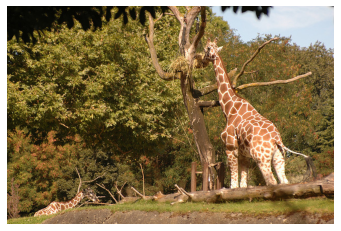

QUESTION
Is the giraffe eating the tree?
MOST COMMON ANSWER
yes


In [32]:
# let's see if it works
ann = train_VQA.dataset["annotations"][89]
print(ann); print()
q = ann["question_id"]
print(q); print() 
# note that ann is equivalent to train_VQA.qa[q], this is an efficient 
# way to retrive the ann given the q, it is useful when doing evaluation
# to have the question id as "primary key" for everything.
print(ann == train_VQA.qa[q]); print()
# print the question
print(train_VQA.qqa[q]); print()
img_id = train_VQA.qqa[q]["image_id"]
img_pth = train_VQA.get_img_from_id(img_id)
print(img_pth); print()

img = io.imread(img_pth)
plt.imshow(img)
plt.axis('off')
plt.show()
print("QUESTION")
print(train_VQA.qqa[q]["question"])
print("MOST COMMON ANSWER")
print(ann["multiple_choice_answer"])

In [48]:
from collections import OrderedDict, Counter
# let's make the vocabs
qst_v = Counter()
ans_v = Counter()

for ann in train_VQA.dataset["annotations"]:
    #TODO BEFORE THE UPDATE THE PREPROCESSING FOR EVALUATIONS
    qst_v.update(train_VQA.qqa[ann["question_id"]]["question"].split())
    ans_v.update(ann["multiple_choice_answer"].split())

In [52]:
print(qst_v.most_common(10))
print(ans_v.most_common(10))

def build_vocab(counter, size):
    w2id = {}
    id2w = {}
    for idx, (i,_) in enumerate(counter.most_common(size)):
        w2id[i]=idx
        id2w[idx]=i
    w2id["OOV"] = idx+1
    id2w[idx+1] = "OOV"
    return w2id, id2w
    
# vocabularies size as in the paper
qv_size = 1000
av_size = 1000
qv_w2id, qv_id2w = build_vocab(qst_v, qv_size)
av_w2id, av_id2w = build_vocab(ans_v, av_size)

print(av_w2id["yes"])

[('the', 322331), ('What', 182835), ('is', 163283), ('Is', 113198), ('this', 75206), ('are', 70828), ('in', 65011), ('a', 57772), ('of', 54655), ('on', 53870)]
[('yes', 84981), ('no', 83659), ('1', 12713), ('2', 12399), ('white', 11163), ('3', 6647), ('blue', 6371), ('black', 6348), ('red', 6241), ('0', 4988)]
0
